In [1]:
    import hopsworks
    import pandas as pd
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    import seaborn as sns
    from matplotlib import pyplot
    from hsml.schema import Schema
    from hsml.model_schema import ModelSchema
    import joblib
    import os
    from sklearn.metrics import f1_score
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import MinMaxScaler
    import xgboost as xgb
    from sklearn.pipeline import Pipeline
    from dotenv import load_dotenv
    import numpy as np


/Users/berkan/Desktop/wine_quality/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()
api_key = os.getenv("HOPSWORKS_API_KEY")

In [3]:
project = hopsworks.login(api_key_value=api_key, project="DD2223_lab1")
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/206996
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
wine_fg = fs.get_feature_group(name="wine_quality", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine_quality",
                                  version=1,
                                  description="Read from Wine Quality dataset",
                                  labels=["quality"],
                                  query=query)

In [ ]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2,shuffle = True)

TypeError: FeatureView.train_test_split() got an unexpected keyword argument 'shuffle'

In [35]:
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()
# X_train = ss.fit_transform(X_train)
# X_test = ss.transform(X_test)

In [36]:
# numeric_features = X_train.select_dtypes(np.number).columns#X.columns
# numeric_cols = X_train[numeric_features]
# # Create a preprocessor with imputation and scaling
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', MinMaxScaler(), numeric_features),
#         #('cat', OrdinalEncoder(), categorical_features)
#     ])
# #Create the pipeline with GradientBoostingClassifier
# model = Pipeline([
#      ('preprocessor', preprocessor),
#     #('classifier', GradientBoostingClassifier(n_estimators = 200,max_depth = 7, random_state=42))
#     ('classifier', xgb.XGBClassifier(n_estimators = 200, learning_rate = 0.1, max_depth = 9))
# ])

In [37]:
y_train = y_train -3
y_test = y_test -3

In [38]:
#model = GradientBoostingClassifier(n_estimators = 200, max_depth = 11, learning_rate = 0.03, random_state=30)
model = xgb.XGBClassifier(n_estimators = 200, learning_rate = 0.1, max_depth = 9)

# Fit the pipeline on the training data
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [39]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Weighted F1 Score: {f1:.4f}')

Weighted F1 Score: 0.5644


In [40]:
from sklearn.metrics import f1_score,accuracy_score
acc = accuracy_score(y_test, y_pred, normalize=True)
acc

0.577570093457944

In [41]:
# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)
results

array([[  0,   0,   3,   1,   0,   0],
       [  1,   3,   9,   4,   1,   0],
       [  0,   3, 141,  59,   3,   0],
       [  0,   0,  37, 130,  23,   1],
       [  0,   0,   1,  61,  32,   0],
       [  0,   0,   0,  12,   7,   3]])

In [11]:
metrics_df = pd.DataFrame(metrics).transpose()
metrics_df

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,7.000000
1,0.190476,0.100000,0.131148,40.000000
2,0.643646,0.618037,0.630582,377.000000
3,0.556985,0.680899,0.612740,445.000000
4,0.450382,0.375796,0.409722,157.000000
5,0.333333,0.051282,0.088889,39.000000
6,0.000000,0.000000,0.000000,0.000000
accuracy,0.564319,0.564319,0.564319,0.564319
macro avg,0.310689,0.260859,0.267583,1065.000000
weighted avg,0.546331,0.564319,0.547829,1065.000000


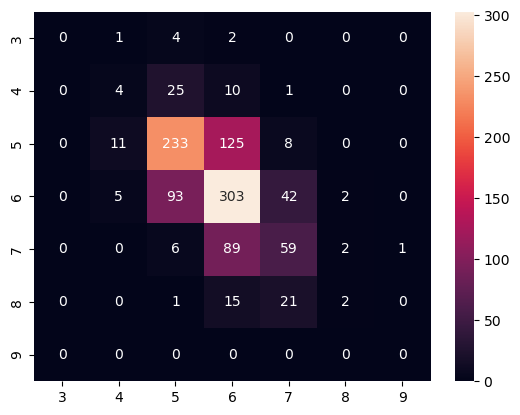

In [12]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, [3 ,4 ,5 ,6, 7, 8, 9],
                     [3 ,4 ,5, 6, 7, 8, 9])
cm = sns.heatmap(df_cm, annot=True, fmt='g')
fig = cm.get_figure()

In [13]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [14]:
# The contents of the 'winequality_model' directory will be saved to the model registry. Create the dir, first.
model_dir="winequality_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

In [15]:
# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/winequality_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")

In [16]:
# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)
model_schema

ModelSchema(input: 'columnar', output: 'columnar')

In [17]:
input_schema

Schema(type: 'columnar')

In [18]:
# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="winequality_model", 
    metrics={"accuracy" : metrics['accuracy'], "f1-score" : metrics["weighted avg"]["f1-score"]},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

In [19]:
# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/206996/models/winequality_model/1


Model(name: 'winequality_model', version: 1)